In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [15]:
def fetch_data(ticker, period='3y'):
    data=yf.download(ticker, period=period)
    data=data[['Open','High','Low','Close','Volume']]
    data.dropna(inplace=True)
    return data


In [11]:
def add_features(data):
    data['Returns']=data['Close'].pct_change()
    data.dropna(inplace=True)
    return data

In [35]:
#Model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [48]:
def simulate_gbm(S0,mu,sigm,T,N,num_paths=100):
    dt=T/N
    t=np.linspace(0,T,N+1)
    paths=np.zeros((num_paths,N+1))
    paths[:,0]=S0

    for i in range(num_paths):
        for j in range(1,N+1):
            dW=np.random.normal(0,np.sqrt(dt))
            paths[i,j]=paths[i,j-1]*np.exp((mu-0.5*sigma**2)*dt+sigma*dW)
    return t,paths

In [37]:
##MAIN
ticker = 'AAPL'
sequence_length = 20
epochs = 10

data = fetch_data(ticker)
data = add_features(data)
prices = data['Close'].values
features = data[['Returns']].values

[*********************100%***********************]  1 of 1 completed


In [38]:
sequences, targets = [], []
for i in range(sequence_length, len(features)):
    sequences.append(features[i-sequence_length:i])
    targets.append(prices[i])

sequences = np.array(sequences)
targets = np.array(targets)


In [39]:
# Scaling
scaler = StandardScaler()
sequences_scaled = scaler.fit_transform(sequences.reshape(-1, sequences.shape[-1]))
sequences_scaled = sequences_scaled.reshape(sequences.shape)

X = torch.tensor(sequences_scaled, dtype=torch.float32)
y = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
##MODEL
model = SimpleLSTM(input_size=features.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
##TRAINING
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(loader):.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([12, 1, 1])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 34927.4197
Epoch 2/10, Loss: 32779.1827
Epoch 3/10, Loss: 31319.3597
Epoch 4/10, Loss: 30096.8095
Epoch 5/10, Loss: 28965.4101
Epoch 6/10, Loss: 27924.8491
Epoch 7/10, Loss: 26931.3740
Epoch 8/10, Loss: 25964.8482
Epoch 9/10, Loss: 25058.1445
Epoch 10/10, Loss: 24121.9855


In [43]:
model.eval()
with torch.no_grad():
  predictions=model(X).squeeze().numpy()

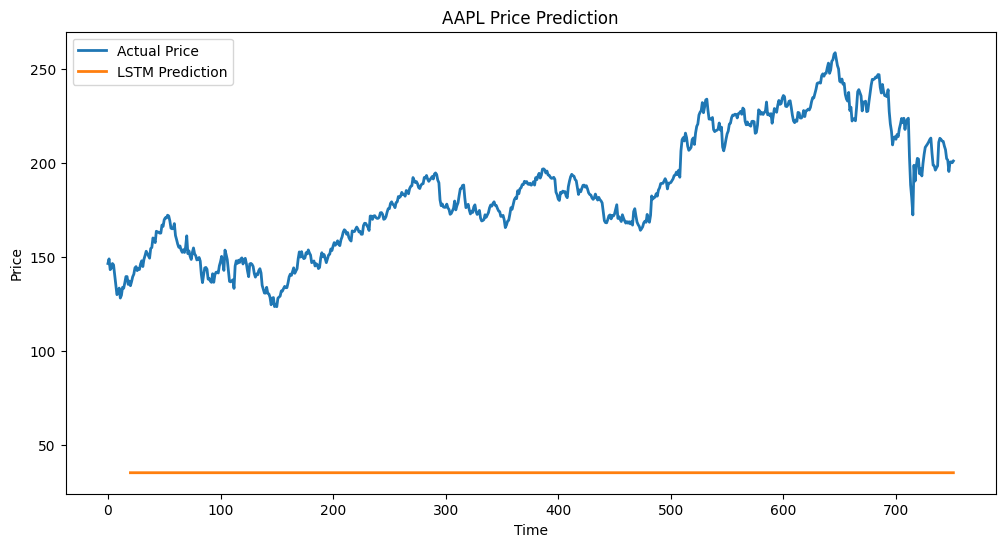

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(prices)), prices, label='Actual Price', linewidth=2)
plt.plot(range(sequence_length, len(prices)), predictions, label='LSTM Prediction', linewidth=2)
plt.legend()
plt.title(f"{ticker} Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

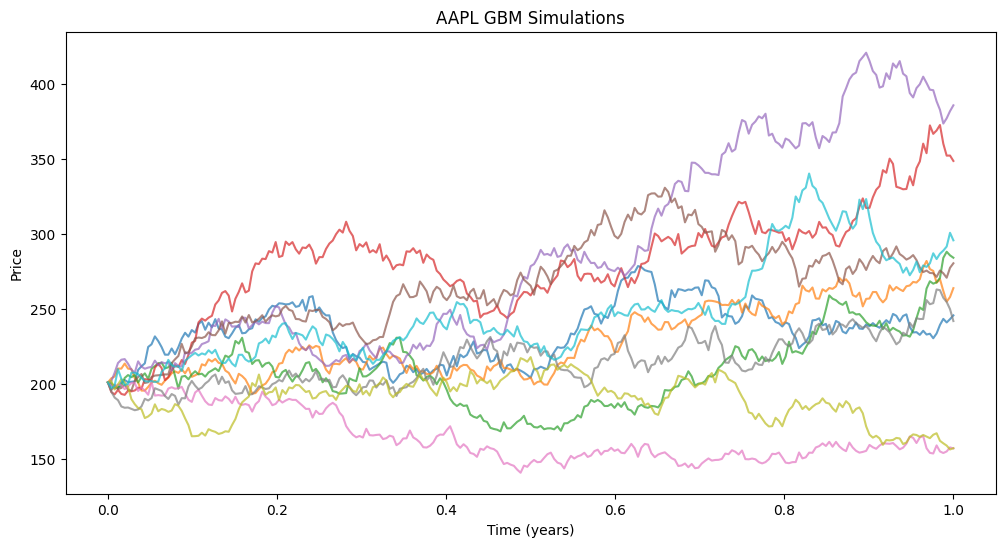

In [49]:
# GBM
mu = np.mean(data['Returns']) * 252
sigma = np.std(data['Returns']) * np.sqrt(252)
S0 = prices[-1]
T = 1
N = 252

t, gbm_paths = simulate_gbm(S0, mu, sigma, T, N)

plt.figure(figsize=(12, 6))
for path in gbm_paths[:10]:
    plt.plot(t, path, alpha=0.7)
plt.title(f"{ticker} GBM Simulations")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.show()